# Microhaplotype candidate panel selection

The aim of this notebook is to analyse all the per-window summary statistics generated in the first notebook, explores panel optimisation and use them to assemble a candidate panel set of markers. The selection process is a challenging mathematical optimisation problem, so here we provide two complementary and effective ways to perform the task. It is worth mentioning that while we show selection methods here, often a subsequent manual curation would be required because of certain constraints, downstream requirements or other considerations (proximity to other markers, reduction of gaps across the genome, low/high diversity regions, or individual assay/panel performance during experimental validation, etc.). The codebase is also modular and can be extended to use different optmisation algorithms if required. 

The notebook consists of four parts:
1. [Environment and data](#Environment-and-data)
1. [Data exploration](#Data-exploration)
1. [Candidate selection](#Candidate-selection) using two different approaches
    1. ["Greedy"](#"Greedy")
    1. [Evenly-spaced](#Evenly-spaced)
1. [Worked example](#Worked-example)

All the data required to run this notebook, as well as the dataframes/files generated in the [previous notebook](windows) are also provided pre-calculated in this repository.

(Environment-and-data)=
## Environment and data

This notebook can be run from any computer and can also work from a compute node within Google Cloud, for example via MyBinder or Google Colab, which are free interactive computing services running in a cloud environment. We primarily use common packages that come pre-installed in many computing environments. However, some specialised packages (e.g. [`malariagen_data`](https://github.com/malariagen/malariagen-data-python)) might require manual installation.

For example, the line below can be uncommented and run on Google Colab to install `malariagen-data` if needed:

In [1]:
#!pip install -q --no-warn-conflicts malariagen-data==7.14.1

First, we load all required packages to get started. 

In [2]:
# Load all required packages and print their version
from importlib.metadata import version
from itertools import cycle

print(f'Numpy version: {version("numpy")}')
print(f'Pandas version: {version("pandas")}')
print(f'Matplotlib version: {version("matplotlib")}')
print(f'scikit-allel version: {version("scikit-allel")}')
print(f'malariagen-data version: {version("malariagen_data")}')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import allel
from malariagen_data.pv4 import Pv4

# Setup plotting backend
%matplotlib inline

Numpy version: 1.23.5
Pandas version: 2.1.3
Matplotlib version: 3.8.2
scikit-allel version: 1.3.7
malariagen-data version: 7.14.1


### Loading the data

Next, we need to load the per-window summary statistics generated in the previous notebook, and prepare the dataframe `windows_df` for analysis. In this example, we use the pre-calculated statistics file stored in this repo called `precomputed/genome_stats.csv`. This can be changed to use a different dataset if required, simply direct it to your file of choice in the first line below. 

We then sort our `windows_df` by chromosome, and then add a column that calculates the midpoint between the `window_start` and `window_end` which will be helpful when we begin to visualise our windows data.

In [3]:
windows_df = pd.read_csv("../precomputed/genome_stats.csv", index_col=0)
windows_df = windows_df.sort_values('chrom')
# Add a supplementary column containing the window midpoint, useful for plotting
windows_df = windows_df.assign(midpoint=windows_df.loc[:, ["window_start", "window_end"]].mean(axis=1))
windows_df.head()

,chrom,window_start,window_end,variant_counts,unique_allele_counts,unique_alleles_with_missing_index,unique_alleles_with_het_index,unique_allele_frequencies,unique_allele_count,entropy,het,midpoint
0,PvP01_01_v1,121301,121500,1,[387 3 225],[],[1],"[0.6292682926829268, 0.004878048780487805, 0.3...",3,0.685315,0.470149,121400.5
380,PvP01_01_v1,634901,635100,3,[ 1 6 235 3 252 23 1 1 4 31 51 7],"[0, 1, 7]","[3, 6]","[0.0016260162601626016, 0.00975609756097561, 0...",12,1.399306,0.674974,635000.5
381,PvP01_01_v1,634951,635150,1,[ 8 291 3 313],[0],[2],"[0.013008130081300813, 0.47317073170731705, 0....",4,0.780273,0.516893,635050.5
382,PvP01_01_v1,636251,636450,1,[ 3 137 3 472],[0],[2],"[0.004878048780487805, 0.22276422764227644, 0....",4,0.589552,0.361303,636350.5
383,PvP01_01_v1,637951,638150,1,[ 1 391 4 219],[0],[2],"[0.0016260162601626016, 0.6357723577235772, 0....",4,0.698831,0.468943,638050.5


We can also quickly check to see how many unique windows were identified in our previous notebook. 

In [4]:
windows_df.shape[0]

13498

Using our selection criteria from Notebook 1, we can see that we have **13,498 potential microhaplotype markers** to choose from across the 14 chromosomes. 

As this analysis is limited to the core genome, we also need to load the boundaries of those regions, which are provided as part of the MalariaGEN Pv4 data package.

In [5]:
pv_regions = pd.read_csv("../supplementary_files/Pv4_regions.bed",
                         sep="\t", comment="t", # this avoids very long strings
                         names=["chrom", "chromStart", "chromEnd", "name"])

# Coordinates are stored as 0-based in the file and need to be adjusted
pv_regions[["chromStart", "chromEnd"]] += 1
# Out of convenience, we add a 'length' column and filter out all non-core regions
pv_regions["length"] = pv_regions["chromEnd"] - pv_regions["chromStart"]
pv_core = pv_regions[pv_regions["name"]=="Core"]
pv_core.head()

,chrom,chromStart,chromEnd,name,length
1,PvP01_01_v1,116542,677963,Core,561421
3,PvP01_01_v1,679790,903592,Core,223802
6,PvP01_02_v1,100156,162349,Core,62193
8,PvP01_02_v1,164088,745644,Core,581556
11,PvP01_03_v1,108062,630664,Core,522602


Finally, we are loading the identifiers (chromosome and position) of the variant selected in the previous notebook. We will use this at the end to add the details of the variants to each selected window.

In [6]:
variant_coords = pd.read_csv("../precomputed/variants_selected.tsv", sep="\t")
variant_coords.head()

,variant_chrom,variant_position
0,PvP01_01_v1,121493
1,PvP01_01_v1,136118
2,PvP01_01_v1,137153
3,PvP01_01_v1,143564
4,PvP01_01_v1,146032


### Load the genomic data
The pre-calculated windows file contain all the information needed for the selection of the panel. This section is only required if you would like to run the last part of this notebook ([Worked example](#Worked-example)), where genomic data are required to calculate the allele frequencies of each variant and prepare the input file for `paneljudge`.

In [7]:
pv4 = Pv4()
sample_metadata = pv4.sample_metadata()
variant_dataset = pv4.variant_calls(extended=True)

In [8]:
pv4_fws = pd.read_csv('../supplementary_files/Pv4_fws.txt', sep='\t', comment='t')
sample_metadata = pd.merge(sample_metadata, pv4_fws, on='Sample', how='outer')

(Data-exploration)=
## Data exploration

This section of the notebook is not strictly required for the subsequent panel selection and can be skipped. However, it provides some basic insights into the diversity of the genome that can later be used to make more informed decisions on marker selection.

First, let's have a look at the distribution of variants per window. **Note the log scale!**

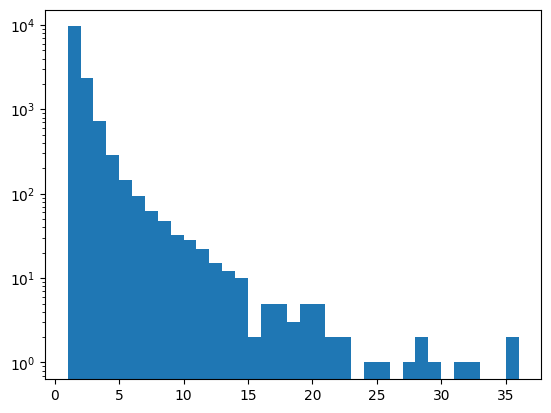

In [9]:
_ = plt.hist(windows_df["variant_counts"],bins=35,log=True)

In [10]:
windows_df["variant_counts"].value_counts().sort_index()

variant_counts
1     9605
2     2369
3      729
4      285
5      146
6       95
7       63
8       48
9       32
10      28
11      22
12      15
13      12
14      10
15       2
16       5
17       5
18       3
19       5
20       5
21       2
22       2
24       1
25       1
27       1
28       2
29       1
31       1
32       1
35       1
36       1
Name: count, dtype: int64

In [11]:
np.count_nonzero(windows_df["variant_counts"] < 3)

11974

Nearly 90% of the windows across the genome only have 1 or 2 variants and thus are not suitable microhaplotype candidates.

Next, let's have a look at the distribution of heterozygosity across the windows.

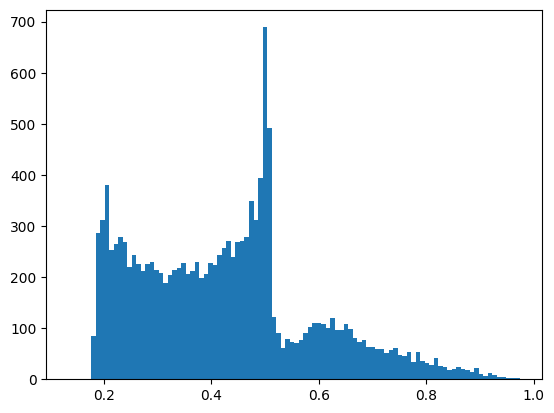

In [12]:
_ = plt.hist(windows_df["het"],100,log=False)

In [13]:
np.count_nonzero(windows_df["het"] >= 0.5)

3830

The distribution is largely skewed towards low values, because of the large number of window with only 1 or 2 variants, where the theortical maximum heterozygosity is 0.5. In total, there are 3,830 windows with heterozygosity greater than or equal 0.5.

For a first rough idea of how many candidates we have, we can combine the two criteria. For example:

In [14]:
len(np.where( (windows_df["het"] >= 0.6) & (windows_df["variant_counts"].between(3,10)) )[0])

1110

Out of the initial list of 13,498 candidate windows, only 1,110 have between 3 and 10 variants and an heterozygosity above 0.6.

Some of these windows will occour in clusters of high diversity along the genome, so we can then decide to look at the distribution of the 13,498 microhaplotype windows across the core genome using a Manhattan plot. The utility function below will plot each window as a dot and concatenate the core regions across the 14 chromosomes.

In [15]:
def plot_man(df, column, palette=["#276FBF", "#183059"]):

    rcParams = plt.rcParams
    rcParams["font.size"] = 12
    rcParams["axes.labelsize"] = 12

    plt.rcParams["xtick.labelsize"]=12
    plt.rcParams["ytick.labelsize"]=12

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel("Chromosome")
    ax.set_ylabel(f'"{column}" per window')

    # Map chromosome numbers to names
    chromosomes = np.sort(df["chrom"].unique())
    chrom_dict = dict(zip(chromosomes, cycle(palette)))

    # Plot the values
    df = df.sort_values(["chrom", "midpoint"])
    ax.scatter(np.arange(len(df)),df[column],c=df["chrom"].apply(lambda x: chrom_dict[x]), s=df[column])

    # Plot the X tick marks
    boundaries = np.nonzero(df["chrom"].shift(1, fill_value=df["chrom"].head(1)) != df["chrom"])
    boundaries = np.insert(boundaries, 0, 0)
    boundaries = np.append(boundaries, len(df))
    ticks = [(a + b) / 2 for a, b in zip(boundaries, boundaries[1:])]
    plt.xticks(ticks, np.arange(1, 15), rotation = 45)

    fig.tight_layout()

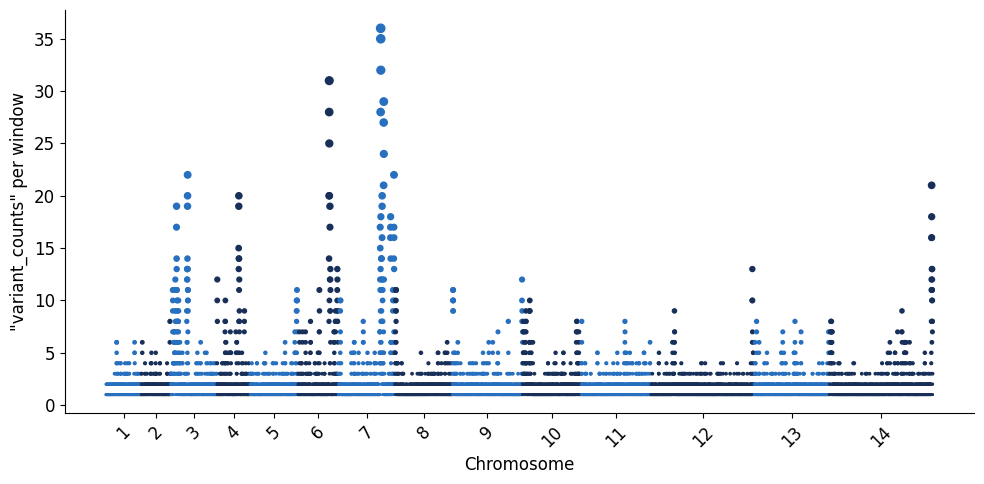

In [16]:
# Plot the number of SNPs per microhaplotype window
plot_man(windows_df, 'variant_counts')

# Rich rainbow colour palette
#rainbow_palette = ['#C62828','#D81B60','#8E24AA','#5E35B1','#3949AB','#1E88E5','#039BE5',
#               '#00ACC1','#00897B','#43A047','#7CB342','#C0CA33','#FFB300','#F4511E']
#plot_man(windows_df, 'variant_counts', rainbow_palette) # for a more colorful version

Similarly, we can visualise the **global heterozygosity** per microhaplotype window, which indicates the overall level of informativeness contained in a given window. In simple terms, heterozygosity in this context can be described as the likelihood of any two parasites having **different** alleles at each microhaplotype (multiallelic) locus. So the higher the heterozygosity value for any window, the higher the chance that any two global parasite lineages selected from the dataset will be unique from each other. Heterozygosity is a valuable statistic to quantify marker informativeness, especially in the context of being able to capture parasite relatedness relationships from sparse data (such as a genotyping panel). 

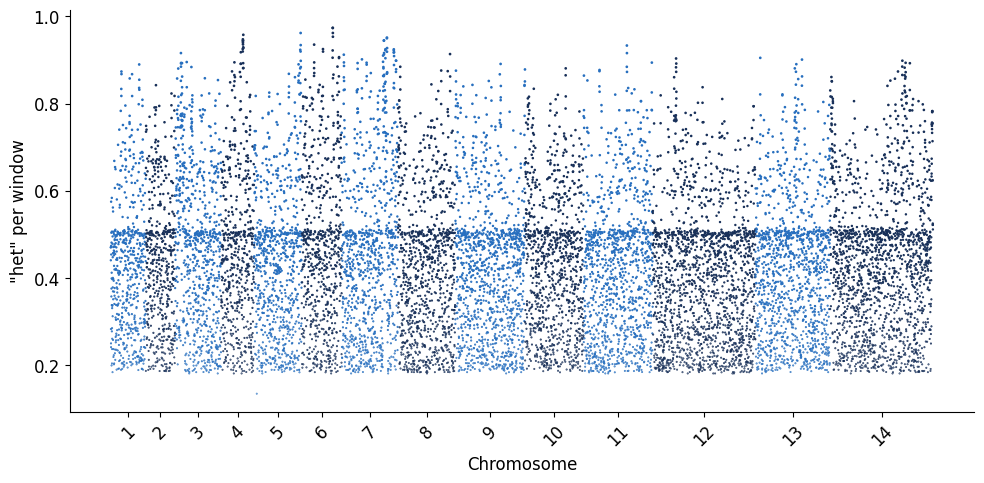

In [17]:
plot_man(windows_df, 'het')

Another canonical way to quantify "information content" is entropu - for more details see [Entropy (information theory)](https://en.wikipedia.org/wiki/Entropy_(information_theory). We can plot the relationship between heterozygosity and entropy below for comparison.   

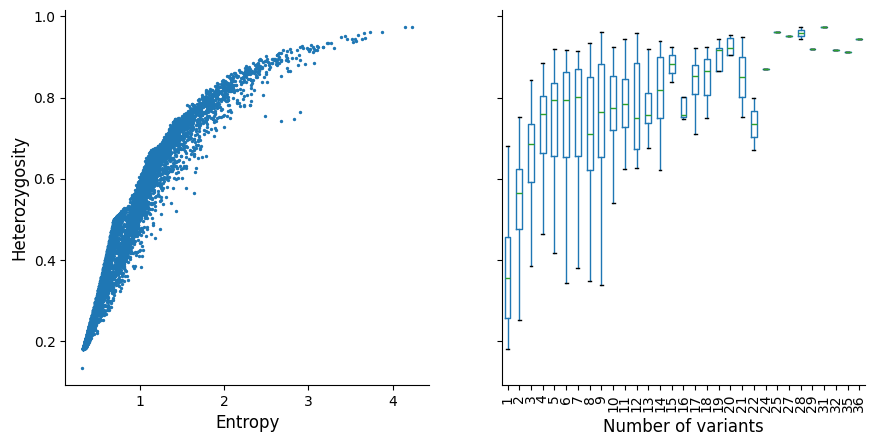

In [18]:
def plot_het_v_entropy(df):

    rcParams = plt.rcParams
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 12

    plt.rcParams['xtick.labelsize']=10
    plt.rcParams['ytick.labelsize']=10

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.scatter(df['entropy'], df['het'], s=2)
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Heterozygosity')

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    boxplot = df.boxplot(column='het', by='variant_counts',
                         rot=90, grid=False, showfliers=False,
                         ax=ax2)
    
    ax2.set_xlabel('Number of variants')
    ax2.set_ylabel('')
    ax2.title.set_text('')
    fig.suptitle('')

plot_het_v_entropy(windows_df)

The left plot indicates that heterozygosity and entropy (both measures of informativeness) are correlated, so for simplicity we have only decided to use heterozygosity as an example here.  

The right plot shows that as the number of variants increases, heterozygosity approaches 1 with diminishing returns as variant count increases. This is one of the reasosns why we decided not to select any windows with more than 10 variants, considering that the number of possible haplotypes exponentially increases. The larger the number of possible haplotypes, the more challenging downstream analyses become computationally (as well as the potential implications on error rate that are compounded with each additional variant per window), so it is pragmatic to keep the number of variants per window as low as possible without sacrificing informativeness.

(Candidate-selection)=
## Candidate selection
Panel selection can be seen as a complex and multidimensional optimisation problem. As shown in [Taylor et al, Genetics 2019](https://doi.org/10.1534/genetics.119.302120), there are several dimensions on which optimal markers should be selected for relatedness estimations. Important considerations from this publication suggest to choose evenly spaced markers across the genome, while simultaneously maximising marker diversity. Additionally, around 100 multiallelic markers were shown to provide sufficient resolution for reconstructing relatedness relationships. From a practical standpoint, there is a trade-off between what is ideal for informativeness maximisation, and even-spacing of markers across the entire genome space. Further, what is reasonable for assay design and implementation of the panel in real-world settings needs to be considered (i.e. number of markers included in an assay, primer design constraints, or how to analyse complex multiallelic data readouts with hundreds/thousands of possible allele combinations). As there are several ways to approach it, here we provide two examples (**greedy** and **evenly spaced**), with the expectation that some level of manual curation will be required to arrive at a final marker set, striking a balance between informativeness, even spacing of markers, and all of the additional considerations needed throughout experimental assay design and marker validation.

### Utility functions

To guarantee that all core regions are represented, we want microhaplotypes to be distributed proportionally to the size of each core region. The utility function below does that and returns the number of expected microhaplotypes per core region, also accounting for rounding errors. This is designed to distribute the number of marker counts proportional to the core region size. Note that this utility function does not space the markers themselves, it simply calculates the number of markers required per core region's length.

In [19]:
def get_n_muhap_per_core(df, n_muhap_total):
    core_length = sum(df["length"])
    # First try with a naive distribution proportional to the region size
    n_muhap_per_core = np.round((df["length"]/core_length)*n_muhap_total).astype('int')

    # Check whether the number obtained is what is required (i.e. if there are rounding effects)
    delta = n_muhap_total - sum(n_muhap_per_core)

    # Supplement the smallest (or deplete the largest) regions if an adjustment is required
    if delta > 0: # Less markers than expected, add to the smallest
        smallest = n_muhap_per_core.nsmallest(delta).index
        n_muhap_per_core[smallest] += 1
    elif delta < 0: # More markers than expected, remove from the largest
        largest = n_muhap_per_core.nlargest(-delta).index
        n_muhap_per_core[largest] -= 1
    
    return n_muhap_per_core

We can then create a visual representation of marker positions across the genome, where:
* white = core regions
* red = subtelomeric regions
* orange = internal hypervariable regions
* blue = centromere

Markers are indicated by vertical lines (black for the selected ones) where the height is proportional to heterozygosity (dotted horizontal line denotes heterozygosity = 0.5).

So we define the palette, and the plotting parameters below. 

In [20]:
regions_pal = {"Cen": "blue", "Core":"None", "In":"orange" , "Sub":"red"}

In [21]:
def plot_markers(df, markers_list, regions):

    rcParams = plt.rcParams
    rcParams['font.size'] = 12
    rcParams['axes.labelsize'] = 10

    #plt.rcParams['xtick.labelsize']=10
    #plt.rcParams['ytick.labelsize']=10
    
    fig, ax = plt.subplots(nrows=14, sharex = True, sharey = True, figsize=(10, 10))

    ax[0].set_xlim([0,regions["chromEnd"].max()])
    ax[0].set_ylim([0,1])
    ax[0].get_xaxis().get_major_formatter().set_scientific(False)
    ax[0].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    markers = df.loc[markers_list]

    for chr_num in range(0,15):
        chr_name = f'PvP01_{chr_num:02}_v1'
    
        chr_regions = regions[regions["chrom"] == chr_name]
        chr_windows = df[df["chrom"] == chr_name]
        chr_markers = markers[markers["chrom"] == chr_name]

        ax[chr_num-1].spines['right'].set_visible(False)
        ax[chr_num-1].spines['top'].set_visible(False)
        ax[chr_num-1].spines['left'].set_visible(False)

        ax[chr_num-1].hlines(0.5,0,np.max(chr_regions["chromEnd"]), color="#CCCCCC",
                              linestyle="dotted", linewidth=0.8, zorder=-1)

        for _, r in chr_regions.iterrows():
            p = mpl.patches.Rectangle((r["chromStart"], -1), r["length"], 2, edgecolor='None', facecolor=regions_pal[r["name"]])
            ax[chr_num-1].add_patch(p)

        ax[chr_num-1].vlines(chr_windows["window_start"],-1,chr_windows["het"], color="#BBBBBB", linewidth=0.8)
        ax[chr_num-1].vlines(chr_markers["window_start"],-1,chr_markers["het"], color="black") 
        ax[chr_num-1].set_ylabel(chr_name, rotation='horizontal', ha='right')
        ax[chr_num-1].set_yticks([])

Finally, we define an additional function that plots some general statistics (average heterozygosity and inter-marker distance) for a given panel.

In [22]:
def plot_panel_stats(windows):

    rcParams = plt.rcParams
    rcParams["font.size"] = 10
    rcParams["axes.labelsize"] = 12

    plt.rcParams["xtick.labelsize"]=10
    plt.rcParams["ytick.labelsize"]=10

    fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)

    windows.sort_values("window_start", inplace=True) # Guarantee they are sorted by position
    
    # Left - Heterozygosity per window and average of the candidate panel
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["top"].set_visible(False)

    ax[0].set_xlabel("Heterozygosity")
    ax[0].set_ylabel("")

    het_values = windows["het"] 
    
    ax[0].hist(het_values,bins=10)
    ax[0].axvline(het_values.mean(), color="darkred", linestyle="dashed", linewidth=1)
    ax[0].axvline(het_values.median(), color="navy", linestyle="dashed", linewidth=1)
    ax[0].set_xlim(0.5,1)

    # Right - Distance between consecutive markers
    ax[1].spines["right"].set_visible(False)
    ax[1].spines["top"].set_visible(False)

    ax[1].set_xlabel("Distance between consecutive windows")
    ax[1].set_ylabel("")

    # Calculate distance between widnows on each chromosome separately
    dist_values = windows.groupby(["chrom"])["midpoint"].diff()
    dist_values.dropna(inplace=True)
    
    ax[1].hist(dist_values,bins=10)
    ax[1].axvline(dist_values.mean(), color="darkred", linestyle="dashed", linewidth=1)
    ax[1].axvline(dist_values.median(), color="navy", linestyle="dashed", linewidth=1)
    ax[1].set_xlim(0,1.5e6)

    # Add text
    _, max_ylim = plt.ylim()
    ax[0].text(het_values.mean()*1.01, max_ylim*0.97, "Mean: {:.2f}".format(het_values.mean()), color="darkred")
    ax[0].text(het_values.median()*1.01, max_ylim*1.01, "Median: {:.2f}".format(het_values.median()), color="navy")
    ax[1].text(dist_values.mean()*1.1, max_ylim*0.97, "Mean: {:,.0f}".format(dist_values.mean()), color="darkred")
    ax[1].text(dist_values.median()*1.1, max_ylim*1.01, "Median: {:,.0f}".format(dist_values.median()), color="navy")

("Greedy")=
### Greedy

Here we show a heuristic method to maximise informativeness at the expense of other considerations, where within each core region, the proportional number of markers (previously calculated above) are selected only on their window's heterozygosity statistic, with the highest heterozygosity windows selected regardless of location in the core region. Then, as a second step, you can apply spacing considerations - where the minimum space between markers can be applied (here 1000 bp of space between markers has been set as the default parameter). In the event that the correct number of markers cannot be found for a region, it gives a warning where it fails to retrieve the desired number of markers per core region. 

For more information, see [Greedy optimisation](https://en.wikipedia.org/wiki/Greedy_algorithm). 

In [23]:
def get_greedy_muhap_list(df, core, n_muhap_per_core, min_distance=1_000):
    
    muhap_list = []

    # Iterate through the core regions one by one
    for (_, row), n_core in zip(core.iterrows(), n_muhap_per_core):
        # Select all windows in the current region and sort them
        core_windows = df[ (df["chrom"] == row["chrom"]) &
                           (df["window_start"] >= row["chromStart"]) &
                           (df["window_end"] <= row["chromEnd"]) ].copy()
        
        local_list = []

        while len(local_list) < n_core:
            # Sort by heterozygosity and pick the top - the "greedy" part
            core_windows.sort_values("het", ascending=False, inplace=True)
            if not np.isnan(core_windows.iloc[0]["midpoint"]):
                local_list += [core_windows.index[0].tolist()] # Add the top window to the list
                midpoint = core_windows.iloc[0]["midpoint"]
                # Mask (i.e. ignore in the next iteration) all windows within min_distance from the current one
                # While the greedy approach doesn't explicitly consider spacing, this small tweak allows to avoid
                # considering clusters of variants multiple times
                core_windows.mask( abs(core_windows["midpoint"] - midpoint) < min_distance, inplace=True)
            else: # If the top marker is NaN, then we are out of options
                print(f'Only {len(local_list)} out of {n_core} windows found in \
{row["chrom"]}:{row["chromStart"]}-{row["chromEnd"]} - try decreasing min_distance')
                break
   
        muhap_list += local_list
    
    return muhap_list


We can apply the heuristic filters we decided on earlier for choosing only windows that have between 3 and 10 variants per window. `windows_subset` can be changed, depending on needs. 

In [24]:
windows_subset = windows_df[windows_df["variant_counts"].between(3,10)]
print(len(windows_subset))

1426


We can then create our **greedy** microhaplotype selection list, and ask for a panel with 100 microhaplotypes - this can be changed as needed. You can then specify the minimum distance between markers, here we have set it to 10,000 as an example. 

In [25]:
n_muhap_total = 100
n_muhap_per_core = get_n_muhap_per_core(pv_core, n_muhap_total)
greedy_muhap_list = get_greedy_muhap_list(windows_subset, pv_core, n_muhap_per_core, 10_000)

Let's plot our greedy microhaplotype marker selection. 

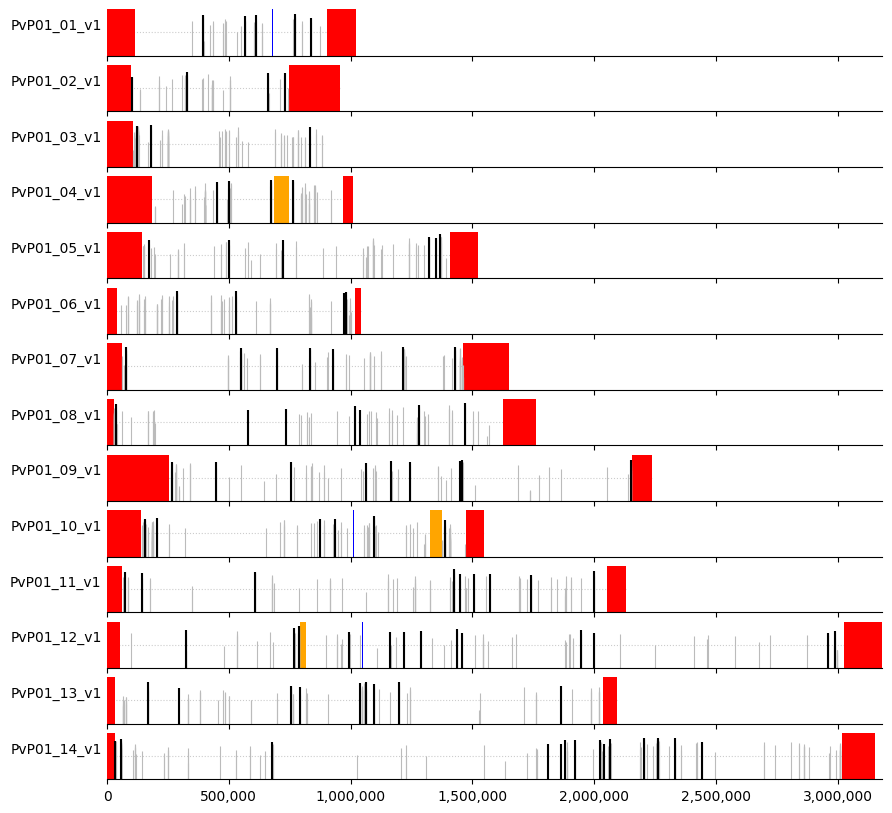

In [26]:
plot_markers(windows_subset,greedy_muhap_list, pv_regions.sort_values(["chrom","chromStart"]))

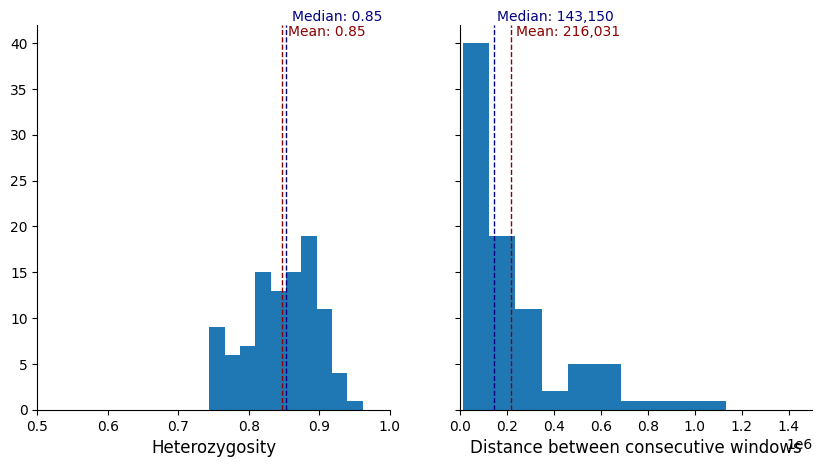

In [27]:
plot_panel_stats(windows_subset.loc[greedy_muhap_list])

We can see that for a marker set of 100, when the markers are prioritised while optimising on informativeness criteria first, and spacing second, there are large gaps between markers, and also regions of the genome where markers clump together (likely higher-diversity regions). If we change the minimum distance (for example to 75,000), we can space them more evenly. 

(Evenly-spaced)=
### Evenly spaced

A different heuristic approach is to optimise based on spacing as a first priority, and informativeness (in this case heterozygosity) as a second priority. This approach decides the minimum spacing desired between markers (default=1000) and then divides each core region into equal sized segments (proportional to the number of markers required per core region), leaving the desired minimum distance gap in between the segments. Then, a sliding window is moved through each segment, identifying the highest heterozygosity marker window within it. 

In [28]:
def get_max_idx(df):
    return df.idxmax()

def get_even_muhap_list(df, core, n_muhap_per_core, spacing=1_000, verbose=False):

    muhap_list = []

    # Iterate through the core regions one by one
    for (_, row), n_core in zip(core.iterrows(), n_muhap_per_core):
        # Select all windows in the current region and sort them
        core_windows = df[ (df["chrom"] == row["chrom"]) &
                           (df["window_start"] >= row["chromStart"]) &
                           (df["window_end"] <= row["chromEnd"]) ].copy()

        core_windows.sort_values("window_start", inplace=True)
        
        local_list = []

        if n_core > 0: # Check that the current region requires at least 1 marker
            # Calculate the size of the sliding window based on the size of the region, the number of markers,
            # and the required minimum buffer spacing between them
            win_size = np.max([0, np.ceil(row["length"]/n_core).astype("int") - spacing])
            # Run a sliding window in the region and for each window get the index of the highest heterozygosity marker
            local_list, a, NN = allel.windowed_statistic(core_windows["midpoint"].astype("int"), core_windows["het"], get_max_idx,
                                                         size=win_size, step=win_size+spacing,
                                                         start=row["chromStart"], stop=row["chromEnd"])
            if np.isnan(local_list).any(): # Check if at least one sliding window didn't find any marker
                print(f'Only {np.count_nonzero(NN)} out of {n_core} windows found in \
{row["chrom"]}:{row["chromStart"]}-{row["chromEnd"]}')
                if verbose:
                    print(f'L:{row["length"]}, W:{win_size}, N:{n_core}')
                    print(a)
                    print(NN)
                local_list = local_list[~np.isnan(local_list)].astype("int")

        muhap_list = [*muhap_list, *local_list]
    
    return muhap_list

Now, we will once again choose which marker windows we would like (variant counts between 3 and 10). 

In [29]:
windows_subset = windows_df[windows_df["variant_counts"].between(3,10)]

We will similarly require 100 markers to be selected, and a minimum distance of 25,000

In [30]:
n_muhap_total = 100
n_muhap_per_core = get_n_muhap_per_core(pv_core, n_muhap_total)
even_muhap_list = get_even_muhap_list(windows_subset, pv_core, n_muhap_per_core, 25_000)
len(even_muhap_list)

Only 2 out of 3 windows found in PvP01_01_v1:116542-677963
Only 0 out of 1 windows found in PvP01_04_v1:566928-685686
Only 5 out of 6 windows found in PvP01_07_v1:60454-1256419
Only 4 out of 5 windows found in PvP01_08_v1:28424-1132375
Only 3 out of 4 windows found in PvP01_10_v1:140990-1011339


95

Here, we can see that if we optimise on spacing first, we cannot get the desired number of markers (100), only 95 are returned. We can adjust the spacing and number of markers until we can select the desired number. 

Let's plot our **evenly spaced** microhaplotype selection. 

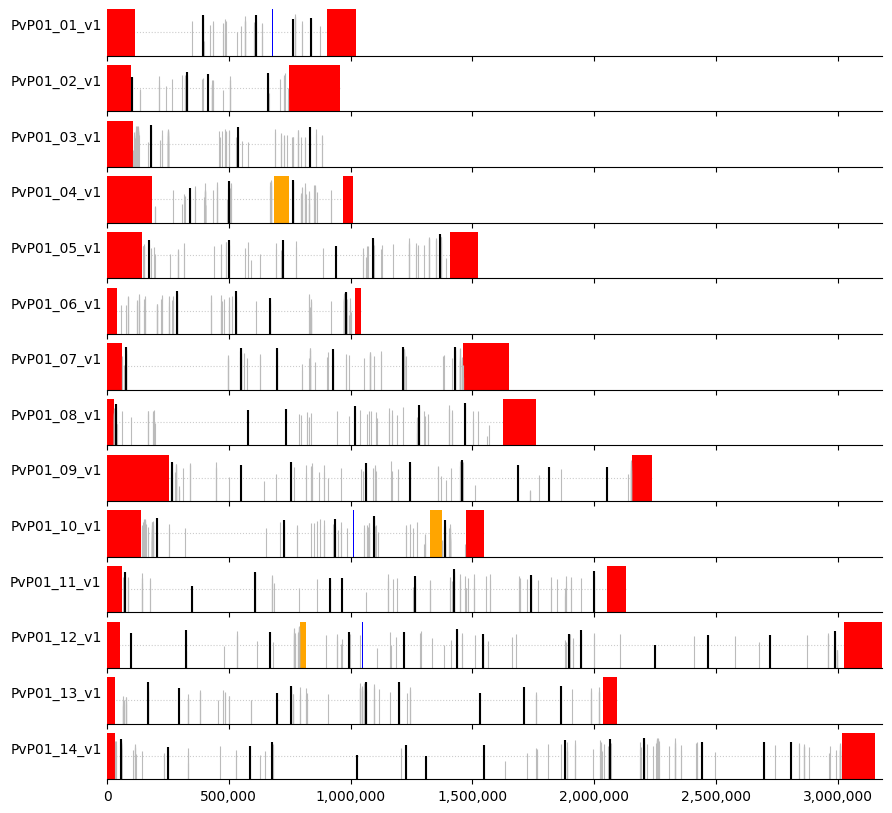

In [31]:
plot_markers(windows_subset,even_muhap_list, pv_regions.sort_values(["chrom","chromStart"]))

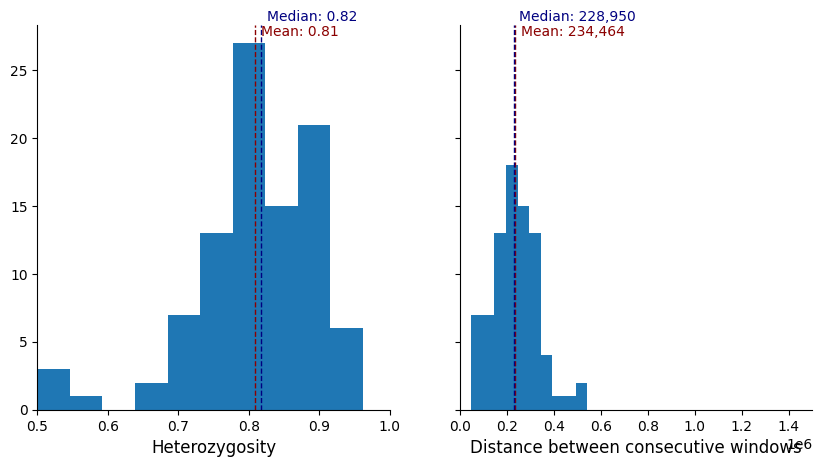

In [32]:
plot_panel_stats(windows_subset.loc[even_muhap_list])

As we can see, there is a definite improvement in spacing of markers, however, a drawback to this approach is that we could be ignoring good microhaplotype windows with high informativeness by insisting that the spacing be consistent between markers.

There are other, more sophisticated (but computationally demanding) approaches to solve this problem, like [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming) which can effectively optimise multiple criteria simultaneously (for example, spacing and heterozygosity). This general framework provides a way to get started and experiment different way to select a candidate set of markers. As mentioned at the beginning, regardless of the bioinformatic method used for the candidate selection, it is very likely that a final manual curation is required to completely satisfy, for example, molecular constraints of the specific platform used.

(Worked-example)=
## Worked example
In this last example we run an example end-to-end, from the design of the panel to the preparation for its evaluation using [paneljudge](https://github.com/aimeertaylor/paneljudge). To simplify the process, we start by defining a number of accessory functions.

First, we will use the function below to map variants to windows they belong to and return the position (absolute and relative) of all the variants it containes.

In [33]:
def win_to_variants(windows, variants):

    # Intialise output dataframe
    df = pd.DataFrame(columns=["id","start","end","length","number","variants"])
    
    for idx, win in windows.iterrows(): # For each selected window
        # Find all variants that fall within the window
        var_idx = np.where((variants["variant_chrom"] == win["chrom"]) &
                           (variants["variant_position"].between(win["window_start"],win["window_end"])))[0]

        n_var = len(var_idx)
        # Throw an error in case the number of variants found doesn't match the expectation
        assert n_var==win["variant_counts"], "Unexpected number of variants - are all files in sync?"
        
        # The microhaplotype unique ID will have the following format:
        # <crhomosome>:<position of variant #1>:[<position of variant #2 relative to #1>, ...]
        relative_pos = variants.loc[var_idx[1:]]["variant_position"] - variants.loc[var_idx[0]]["variant_position"]
        mhap_id = f'{":".join(str(x) for x in variant_coords.loc[var_idx[0]])}:{",".join(str(x) for x in relative_pos)}'
        
        mhap_start = variants.loc[var_idx[0]]["variant_position"]
        mhap_end = variants.loc[var_idx[-1]]["variant_position"]
        mhap_length = mhap_end - mhap_start

        # For convenience, also include the absolute position of all variants in the window
        var_list=[]
        for v in var_idx:
            var_list += [":".join(str(x) for x in variant_coords.loc[v])]

        # Add a new row to the dataframe. The index matches the one in the 'windows' dataframe, useful for merging
        df.loc[idx] = {"id":mhap_id, "start":mhap_start, "end":mhap_end, "length":mhap_length,
                       "number":n_var, "variants":";".join(var_list)}

    return df

`paneljudge` treats each microhaplotype as a single variant rather than a collection of individual ones. The microhaplotype frequencies are a required input to run the simulations and the function below calculates them. For a given microhaplotype and the variants it contains, the function extracts the sample genotypes and transforms them into *haplotypes* (i.e. the concatenation of the allele state of each variant). For example, if a microhaplotype contains two biallelic SNPs, there are up to four theoretical haplotypes possible (ab, Ab, aB, AB) corresponding to as many microhaplotype alleles.

Before calculating frequencies, we need to define a strategy to handle "heterozygous" (i.e. the sample contains a collection of parasites with different alleles in that position) and "missing" (i.e. not enough reads to confidently output an allele) genotype calls. The strict sample selection criteria mean that those calls are overall very rare, to the point that different approaches have very limited impact on the final results. Because of that and for the sake of simplicity, we decided to exclude any haplotype containing missing calls and randomly select one of the alleles in heterozygous calls (done under the hood by the `scikit-allel` function `haploidify_samples()`). We explicitly define the random seed for reproducibility purposes.

This is all handled within the function below:

In [34]:
def haplotype_freq(amplicon, variants, seed=250523):
    
    muhap = amplicon.split(";")
    va=variants.sel(variants=muhap)
    gt = allel.GenotypeArray(va["call_genotype"].data)
    
    np.random.seed(seed)
    haplo = gt.haploidify_samples().astype(str)
    haplo_str = ["".join(x) for x in haplo.transpose()]
    haplo_non_missing = [h for h in haplo_str if "-" not in h]

    values, counts = np.unique(haplo_non_missing, return_counts=True)

    freqs = np.sort(counts/np.sum(counts))[::-1]
    freqs = np.round(freqs,decimals=5)
    
    return freqs

To create our example panel, we begin by selecting only the windows that satisfy our minimum criteria, in this example between 3 and 10 variants and heterozygosity of at least 0.6.

In [35]:
windows_subset = windows_df[(windows_df["variant_counts"].between(3,10))&(windows_df["het"] >= 0.6)]
len(windows_subset)

1110

We then select 50 evenly-spaced windows and visualise some basic summary statistics for the panel using the functions defined above: 

In [36]:
n_muhap_per_core = get_n_muhap_per_core(pv_core, 50)
muhap_list = get_even_muhap_list(windows_subset, pv_core, n_muhap_per_core, spacing=10_000)

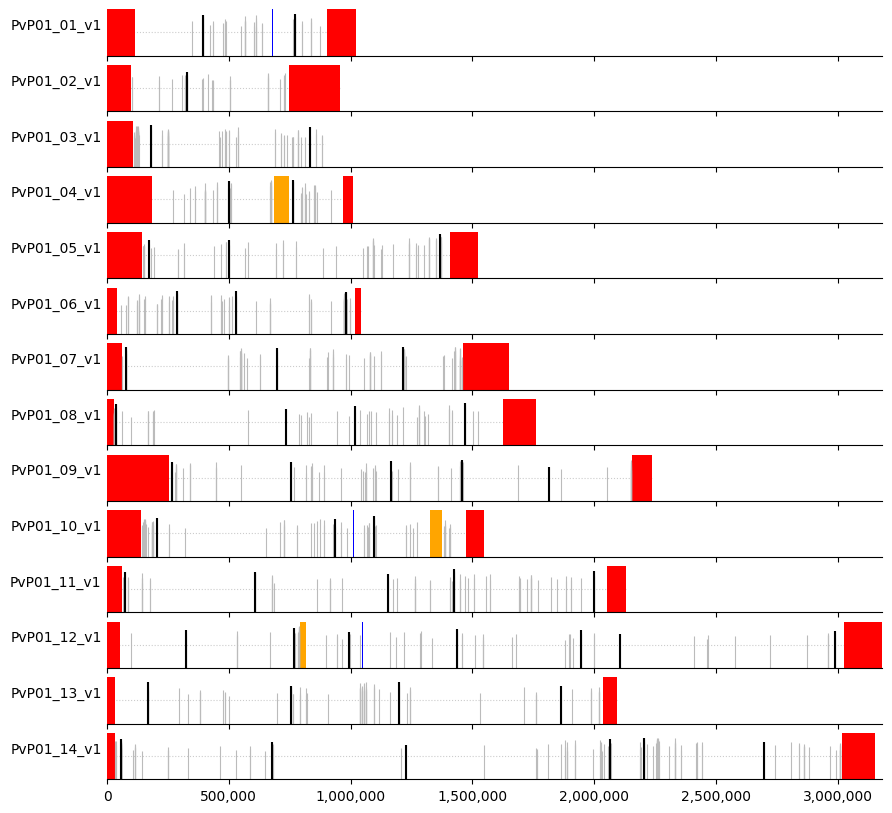

In [37]:
plot_markers(windows_subset,muhap_list, pv_regions.sort_values(["chrom","chromStart"]))

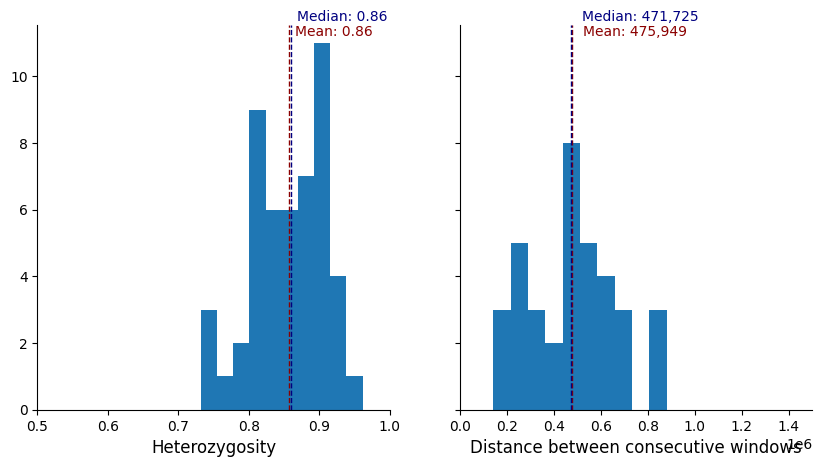

In [38]:
plot_panel_stats(windows_subset.loc[muhap_list])

At this point we could experiment with other selection algorithms, different parameters, introduce some degree of manual curation, etc. Once happy, we can proceed to extracting the actual list of variants:

In [39]:
panel=win_to_variants(windows_subset.loc[muhap_list], variant_coords)
panel.head()

,id,start,end,length,number,variants
175,"PvP01_01_v1:395454:27,40,55,67,154",395454,395608,154,6,PvP01_01_v1:395454;PvP01_01_v1:395481;PvP01_01...
467,"PvP01_01_v1:772094:42,60,64,65,117",772094,772211,117,6,PvP01_01_v1:772094;PvP01_01_v1:772136;PvP01_01...
742,"PvP01_02_v1:327553:35,63,129,186",327553,327739,186,5,PvP01_02_v1:327553;PvP01_02_v1:327588;PvP01_02...
1247,"PvP01_03_v1:178938:83,84,152,156",178938,179094,156,5,PvP01_03_v1:178938;PvP01_03_v1:179021;PvP01_03...
1760,"PvP01_03_v1:831863:12,111,135",831863,831998,135,4,PvP01_03_v1:831863;PvP01_03_v1:831875;PvP01_03...


In [40]:
panel["number"].sum()

285

There are in total 285 variants across the 50 selected windows.

We are now ready to prepare the input files for `paneljudge`. In order to do so, we need to decide which samples (or population) to use to calculate the haplotype frequencies. As an example, let's use samples from the eastern part of Southeast Asia (see the Pv4 paper for details on how populations are defined based on geographic and genetic homogeneity):

In [41]:
# Filter the samples based on the criteria above
loc_filtered_samples = (
    (sample_metadata["Population"] == "ESEA")
    & (sample_metadata["Fws"] > 0.95)
    & (sample_metadata["% callable"] > 50)
    & (sample_metadata["Exclusion reason"] == "Analysis_set")
)
subset_metadata = sample_metadata[loc_filtered_samples]
print(len(subset_metadata))
variant_dataset_filtered_samples = variant_dataset.isel(samples=loc_filtered_samples)

161


The next part speeds-up the computation by reducing the genomics data to the 161 samples and 285 variants needed.

In [42]:
variables_to_remove = list(variant_dataset_filtered_samples.keys()) # Add all variable names to remove list...
variables_to_remove.remove("call_genotype") # ...but we need to keep the genotypes
reduced_variant_set = variant_dataset_filtered_samples.drop_vars(variables_to_remove) # Reduce the dataset

# Pre-load the data to avoid continuous query to the cloud. Not strictly speaking necessary.
ids = [f"{c}:{p}" for c,p in zip(variant_dataset_filtered_samples.coords["variant_chrom"].values,
                                 variant_dataset_filtered_samples.coords["variant_position"].values)]
reduced_variant_set["id"]=("variants",ids)
all_variants = reduced_variant_set.set_index(variants="id")
all_variants

<xarray.Dataset>
Dimensions:           (variants: 4571056, samples: 161, ploidy: 2)
Coordinates:
    variant_position  (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_chrom     (variants) object dask.array<chunksize=(65536,), meta=np.ndarray>
    sample_id         (samples) object dask.array<chunksize=(161,), meta=np.ndarray>
  * variants          (variants) <U33 'PvP01_01_v1:23' ... 'Transfer.PvP01_00...
Dimensions without coordinates: samples, ploidy
Data variables:
    call_genotype     (variants, samples, ploidy) int8 dask.array<chunksize=(65536, 2, 2), meta=np.ndarray>

The final step is to create actual input files by going through all microhaplotypes one by one.

In [43]:
def create_pj_files(panel, variants):

    # Initialise the dataframe
    pj = pd.DataFrame(columns=["Amplicon_name","Chr","Start","Stop","length","pos","chrom","distances","freqs"],index=panel["id"])

    # Interate through each window/microhaplotype
    for _, amplicon in panel.iterrows():

        # Convert chromosome names to number (e.g. 'PvP01_07_v1' -> 13)
        chr_name = amplicon["id"].split(":")[0]
        chr_num = int(chr_name.split("_")[1])

        # Fill in all fields required by paneljudge
        pj.loc[amplicon["id"]]["Amplicon_name"] = amplicon["id"]
        pj.loc[amplicon["id"]]["Chr"] = chr_name
        pj.loc[amplicon["id"]]["Start"] = amplicon["start"]
        pj.loc[amplicon["id"]]["Stop"] = amplicon["end"]
        pj.loc[amplicon["id"]]["length"] = amplicon["end"]-amplicon["start"]
        pj.loc[amplicon["id"]]["pos"] = np.floor(np.mean([amplicon["start"],amplicon["end"]])).astype("int")
        pj.loc[amplicon["id"]]["chrom"] = chr_num
        # This step is the most demanding as it requires access to the genomic data
        pj.loc[amplicon["id"]]["freqs"] = haplotype_freq(amplicon["variants"], variants)

        # Finally, calculate the forward intra-markers distance
        for i, _ in enumerate(pj.iterrows()):
            if i < (len(pj)-1):
                if pj.iloc[i]["chrom"] == pj.iloc[i+1]["chrom"]:
                    pj.iloc[i]["distances"] = pj.iloc[i+1]["pos"]-pj.iloc[i]["pos"]
                else:
                    pj.iloc[i]["distances"] = "Inf"
            else:
                pj.iloc[i]["distances"] = "Inf"
    
    return pj

In [44]:
%%time
pj_df = create_pj_files(panel,all_variants)

CPU times: user 20.6 s, sys: 2.8 s, total: 23.4 s
Wall time: 3min 27s


Data are ready to be saved in tsv files to be later processed in R. We need two files, one containing the microhaplotype marker details (genomic position, etc), and one containing the frequency of each allele (per sub-population).

In [45]:
# Save the markers file
pj_df.drop(columns="freqs").to_csv("../precomputed/markers.tsv", index_label="", sep="\t")
# paneljudge requires the frequencies to be linearised (one row per microhaplotype, one column per allele)
# The next lines calculates how many columns are required (max number of alleles across all microhaplotypes)
ff = pj_df["freqs"].to_list()
max_alleles = np.max([i.size for i in ff])
# Create and save the frequencies dataframe
pj_freqs = pd.DataFrame.from_records(ff,index=pj_df["Amplicon_name"],
                                    columns=[f"Allele.{i}" for i in np.arange(max_alleles)]).fillna(0)
pj_freqs.to_csv("../precomputed/frequencies.tsv", index_label="", sep="\t")
pj_freqs.head()

,Allele.0,Allele.1,Allele.2,Allele.3,Allele.4,Allele.5,Allele.6,Allele.7,Allele.8,Allele.9,...,Allele.29,Allele.30,Allele.31,Allele.32,Allele.33,Allele.34,Allele.35,Allele.36,Allele.37,Allele.38
Amplicon_name,,,,,,,,,,,,,,,,,,,,,
"PvP01_01_v1:395454:27,40,55,67,154",0.44720,0.18634,0.12422,0.06211,0.05590,0.04969,0.02484,0.02484,0.00621,0.00621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"PvP01_01_v1:772094:42,60,64,65,117",0.51899,0.25316,0.05063,0.03797,0.03797,0.02532,0.02532,0.02532,0.01899,0.00633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"PvP01_02_v1:327553:35,63,129,186",0.48447,0.11801,0.09317,0.06832,0.06211,0.05590,0.03106,0.01863,0.01242,0.01242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"PvP01_03_v1:178938:83,84,152,156",0.37736,0.23899,0.19497,0.16352,0.01258,0.00629,0.00629,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"PvP01_03_v1:831863:12,111,135",0.31013,0.22152,0.13924,0.11392,0.05063,0.04430,0.03165,0.02532,0.01899,0.01266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The two files (in this example `markers.tsv` and `frequencies.tsv` in the `precomputed` directory) are now ready to be read in R before running `paneljudge`. The snippet of R code below is an example on how to do that:
```R
library(paneljudge)
set.seed(250523) # For reproducibility

# Read the data
markers_info <- read.delim("markers.tsv",stringsAsFactors = F)[,-1]
freq_values <- read.delim("frequencies.tsv",stringsAsFactors = F)

# Prepare the necessary data structures
rownames(markers_info) = markers_info$Amplicon_name
markers_info$pos <- as.numeric(markers_info$pos)
markers_info$chrom <- as.numeric(markers_info$chrom)

frequency_values<-list("ESEA" = data.matrix(freq_values[,-1]))
dimnames(frequency_values$ESEA)[[1]]<-freq_values[,1]
dimnames(frequency_values$ESEA)[[2]]<-names(freq_values[,-1])
attr(frequency_values,"split_type")<-"data.frame"
attr(frequency_values,"split_labels")<-data.frame("Country"="ESEA",stringsAsFactors = F)

# Save the data structures for future use
save("markers_info", file="markers.RData")
save("frequency_values", file="frequencies.RData")

# Simulate n genotype pairs, r in rs, and k in ks
# Relatedness values
rs <- c("0.01"=0.01, "0.25"=0.25, "0.50"=0.50, "0.75"=0.75, "0.99"=0.99)
# Switch rates
ks <- c('1'=1,'5'=5,'10'=10,'50'=50)

# Number of pairs to per simulate per r in rs and k in ks
n <- 100

# Run the simulations
ds <- markers_info$distances # Distances
mles_CIs <- lapply(frequency_values, function(fs) {
  lapply(ks, function(k) {
    lapply(rs, function(r) {
      lapply(1:n, function(i) {
        sim_Ys <- simulate_Ys(fs, ds, k, r) # Stimulate data
        krhat <- estimate_r_and_k(fs, ds, Ys = sim_Ys) # Estimate k and r
        CIs <- compute_r_and_k_CIs(fs, ds, krhat['khat'], krhat['rhat']) # CIs
        return(cbind(krhat, CIs)) # Return mles and CIs
      })
    })
  })
})

# Save the results
save(mles_CIs, file = 'mles_CIs.RData')
```